Code for calculating velocity auto-correlation function $\xi_{vv,l}$
multipole in real space, using the module DDsmu

In [99]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from hankel import HankelTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path ='/Users/ngoc/Desktop/Master-study/project'

In [100]:
#cosmological parameters
z        = 0.306                   #redshift
f        = 0.687255861             #growth rate
Omg_lamb = 0.685                   #dark energy density parameter
Omg_m    = 1. - Omg_lamb           #matter density parameter
a        = 1./(1. + z)             #scale factor
E_a      = np.sqrt(Omg_m*(1.+z)**3. + Omg_lamb) 


In [101]:
#simulation parameters
boxsize  = 2000                    #length of the box [Mpc/h]
nthreads = 4                       #number of Open MP threads to use 
autocorr = 1                       #auto correlation
nbins    = 50                      #number of bins
rmin     = 1.                      #minimum separation [Mpc/h]
rmax     = boxsize/3               #maximum separation [Mpc/h]
bins     = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)     
mu_max   = 1                       #maximum value of cosine of the angle separated from the LOS
nmu_bins = 10                      #number of bins of the angle separation 
delta_mu = mu_max/nmu_bins


In [129]:
#Legendre polynomials
P0 = 1
P_2 = lambda mu: (3*mu**2-1)/2

In [103]:
k   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (0))
P   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (1))
P_k = spline(k, P)

In [104]:
# load positions of objects
X = np.loadtxt(path+'/catalogs/13/gals/2gpc/R113_S014_clu_d.cat', usecols = (1))
Y = np.loadtxt(path+'/catalogs/13/gals/2gpc/R113_S014_clu_d.cat', usecols = (2))
Z = np.loadtxt(path+'/catalogs/13/gals/2gpc/R113_S014_clu_d.cat', usecols = (3))

# load velocities of objects
V_z     = np.loadtxt(path+'/catalogs/13/gals/2gpc/R113_S014_clu_d.cat', usecols = (6))
weights = V_z/(a*E_a*100)
    
#calculate random-random pairs 
N    = len(X)          # number of halos
RR   = 4./3.*np.pi*(bins[1::]**3 - bins[0:-1:]**3)*N*(N-1)/boxsize**3
  

In [116]:
  
# using DDsmu to calculate pair in each mu bin
results_DDsmu = DDsmu(autocorr, 
                          nthreads,
                          bins,
                          mu_max,
                          nmu_bins,
                          X, Y, Z,
                          weights1    = weights,
                          boxsize     = boxsize,
                          weight_type = 'pair_product',
                          output_savg = True,
                          periodic    = True)
  
npair   = results_DDsmu['npairs']
weight_avg  = results_DDsmu['weightavg']
mu      = results_DDsmu['mu_max']
r_mu    = results_DDsmu['savg']
DD_r_mu = npair*weight_avg

In [106]:
#monopole
DD_r= np.zeros(nbins)      
xi0 = np.zeros(nbins)
r0  = np.zeros(nbins)
l   = 0 
for ii in range(0,nbins):
    for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        xi0[ii] += DD_r_mu[j]/(RR[ii]/nmu_bins)*P0*delta_mu    
        r0[ii]  += r_mu[j]  
        
xi0 *= (2*l+1)
r0  /= nmu_bins

In [107]:
 
#quadrupole
            
xi2 = np.zeros(nbins)
l   = 2
    
for ii in range(0,nbins):
    for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        xi2[ii] += DD_r_mu[j]/(RR[ii]/nmu_bins)*delta_mu*P2(mu[j])
   
xi2  *= (2*l+1)

In [108]:
# xi_vv monopole Linear theory
f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)

h1    = HankelTransform(nu=1/2, N = 3000, h = 1e-5)
xi_mono = 1/np.sqrt(r)*h1.transform(f1,r, ret_err=False, inverse=True)  

xi_th0 = f**2*xi_mono/3

In [109]:
# xi_vv quadrupole Linear theory

h2    = HankelTransform(nu=5/2, N = 3000, h = 1e-5)

f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)
xi_p2 = 1/np.sqrt(r)*h2.transform(f1,r, ret_err=False, inverse=True)
xi_th2 = -2/3*f**2*xi_p2


In [110]:
# load result from F-corrfunc
# note that I already multiply weights to the pairs count DDsmu_f
DDsmu_f = np.loadtxt(path+'/my-f-code/results/xi-vv.txt', usecols = (0))
rsmu_f  = np.loadtxt(path+'/my-f-code/results/xi-vv.txt', usecols = (1))
mu_f    = np.loadtxt(path+'/my-f-code/results/xi-vv.txt', usecols = (2))
#weight_f = np.loadtxt(path+'/my-f-code/results/xi-vv.txt', usecols = (3))

In [112]:
xi0_f = np.zeros(nbins)
r0_f = np.zeros(nbins)
l   = 0 
for ii in range(0,nbins):
    RR_mu = RR[ii]/nmu_bins
    for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        xi0_f[ii] +=  DDsmu_f[j]/RR_mu*P0*delta_mu#*weight_f[j]    
        r0_f[ii]  += rsmu_f[j]  
       
xi0_f *= (2*l+1)
r0_f  /= nmu_bins
            
xi2_f = np.zeros(nbins)
l   = 2
    
for ii in range(0,nbins):
    RR_mu = RR[ii]/nmu_bins
    for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        xi2_f[ii] += DDsmu_f[j]/RR_mu*delta_mu*P2(mu_f[j])#*weight_f[j]
   
xi2_f *= (2*l+1)
    


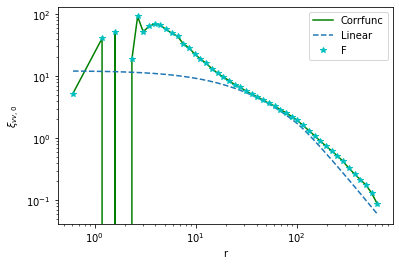

In [125]:
# monopole
plt.loglog(r,xi0,'g-', label ='Corrfunc')
plt.plot(r,xi_th0, '--',label='Linear')
plt.plot(r,xi0_f,'c*',label ='F')
plt.legend()
plt.xlabel('r')
plt.ylabel('$\\xi_{vv,0}$')
#plt.savefig('vvmono.png')

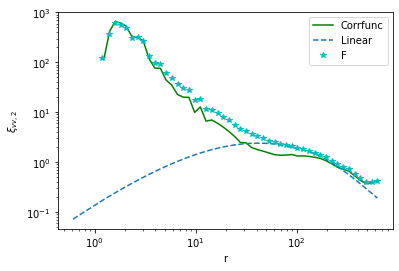

In [126]:
# quadrupole
plt.loglog(r0_f,-xi2,'g-', label='Corrfunc')
plt.plot(r,-xi_th2,'--', label ='Linear')
plt.plot(r,-xi2_f,'c*',label='F')
plt.xlabel('r')
plt.ylabel('$\\xi_{vv,2}$')
#plt.xlim(10,)
plt.legend()
#plt.savefig('vvquad.png')

Results for all 8 realizations and average of them,
calculating time   2162.4785179999999  seconds ~ 36mins

In [127]:
ndata    = 8                       #number of realizations
realizations = "12345678"         #for reading the data
A_0 = np.zeros((ndata,nbins))
r   = np.zeros((ndata,nbins))
A_2 = np.zeros((ndata,nbins))

In [142]:
for i in range (0,ndata):

    #load results for 8 realization
    DDsmu_f = np.loadtxt(path+'/my-f-code/results/xi-vv-realization'+realizations[i]+'.txt', usecols = (0))
    rsmu_f  = np.loadtxt(path+'/my-f-code/results/xi-vv-realization'+realizations[i]+'.txt', usecols = (1))
    mu_f    = np.loadtxt(path+'/my-f-code/results/xi-vv-realization'+realizations[i]+'.txt', usecols = (2))
   
    X = np.loadtxt(path+'/catalogs/1'+realizations[i]+'/gals/2gpc/R11'+realizations[i]+'_S014_clu_d.cat', usecols = (1))
   
    N  = len(X)                                          #number of halos
    V  = 4/3*np.pi*(bins[1::]**3 - bins[0:-1:]**3)
    RR = V*N*(N-1)/boxsize**3
    
    #monopole      
    xi0_f = np.zeros(nbins)
    r0_f  = np.zeros(nbins)

    l = 0 
    for ii in range(0,nbins):
        RR_mu = RR[ii]/nmu_bins
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
        
            xi0_f[ii] += (DDsmu_f[j]/RR_mu)*P0*delta_mu   
            r0_f[ii]  += rsmu_f[j]
        
    r0_f /= nmu_bins
    
    A_0[i] = xi0_f
    r[i]   = r0_f    
    
    #quadrupole
    xi2_f = np.zeros(nbins)

    l = 2 
    for ii in range(0,nbins):
        RR_mu = RR[ii]/nmu_bins
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi2_f[ii] += (DDsmu_f[j]/RR_mu)*delta_mu*P_2(mu_f[j])

    xi2_f *= (2*l+1)
    A_2[i] = xi2_f
    
    

In [143]:
# calculate the average of 8 realizations and error bars

#monopole
xi_vv0 = np.zeros(nbins)
r_vv      = np.zeros(nbins)

for i in range(0,nbins):
    r_vv[i]   = np.mean(r[0:ndata,i])
    xi_vv0[i] = np.mean(A_0[0:ndata,i])


error_xi_vv0 = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_0[j,i] - xi_vv0[i])**2.
    error_xi_vv0[i] = np.sqrt(a/(ndata-1)) #standard deviation
serror_xi_vv0 = error_xi_vv0/np.sqrt(ndata)

#quadrupole
xi_vv2 = np.zeros(nbins)
for i in range(0,nbins):
    xi_vv2[i] = np.mean(A_2[0:ndata,i])

error_xi_vv2 = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_2[j,i] - xi_vv2[i])**2
    error_xi_vv2[i] = np.sqrt(a/(ndata-1))
serror_xi_vv2 = error_xi_vv2/np.sqrt(ndata)


Text(0.5, 0, 's[Mpc$.h^{-1}$]')

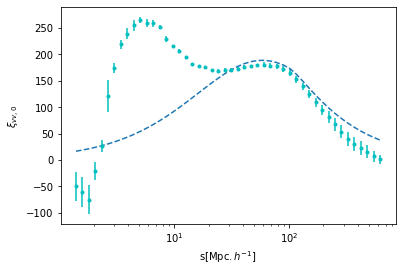

In [152]:
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.errorbar(r_vv, xi_vv0*r_vv, fmt ='c.',yerr = serror_xi_vv0*r_vv ,label="F-avg")
ax.plot(r_vv, xi_th0*r_vv, '--',label="Linear")
ax.set_ylabel("$\\xi_{vv,0}$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
#ax.set_xlim(1,100)
#ax.set_ylim(-100,350)
#ax.legend()
#plt.savefig('Fmono.png')

(-100.0, 350.0)

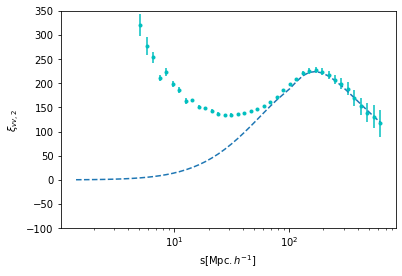

In [149]:
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.errorbar(r_vv, -xi_vv2*r_vv, fmt ='c.',yerr = serror_xi_vv2*r_vv ,label="F-avg")
ax.plot(r_vv, -xi_th2*r_vv, '--',label="Linear")
ax.set_ylabel("$\\xi_{vv,2}$")
ax.set_xlabel("s[Mpc$.h^{-1}$]")
#ax.set_xlim(1,100)
ax.set_ylim(-100,350)
#ax.legend()
#plt.savefig('Fmono.png')